In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import tomasi_kanade as tk
from visualization import plot3d, plot_result
from random import seed

/opt/homebrew/lib/python3.11/site-packages/chainer/_environment_check.py:33: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  warnings.warn('''\


In [2]:
seedval = seed(1)

In [3]:
# collecting video frames
frames = []
cap = cv2.VideoCapture("/Users/max/Desktop/Swifty/data/indoor_hallway/video.avi")

if not cap.isOpened():
    print("Error: Could not open video file")
else:
    while True:
        ret, frame = cap.read()
        # trigger for EOL
        if not ret: break
        frames.append(frame)
cap.release()

# frame selection
# collecting just the first second
frames = frames[:5] 

In [4]:
def to_viewpoints(M):
    x = np.array([1, 0, 0])

    def to_viewpoint(M):
        m = np.cross(M[0], M[1])
        R = np.vstack((M, m))
        return np.dot(R, x)

    F = M.shape[0] // 2
    return np.array([to_viewpoint(M_) for M_ in np.split(M, F)])

In [5]:
help(hash) # need to freeze the seed 

Help on built-in function hash in module builtins:

hash(obj, /)
    Return the hash value for the given object.
    
    Two objects that compare equal must also have the same hash value, but the
    reverse is not necessarily true.



In [6]:
# creating features
# initializing ORB feature detector
orb = cv2.ORB_create()

# collecting features across all 5 frames
features = []
for f in frames:
    kpi, di = orb.detectAndCompute(f, None)
    features.append((kpi, di))

# FLANN parameters.
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=100) 

# feature matrix
good = []
# match matrix
mm = []

# feature matching
for f in range(len(frames)-1):
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    mm.append(flann.knnMatch(features[f][1],features[f+1][1], k=2))

# selecting only good matches across all frames
for f in range(len(frames)-1):
    for i,(m,n) in enumerate(mm[f]):
        if m.distance < 0.7*n.distance:
            good.append((f, m))

# flattening the matches, tracking the descriptors
flat = {hash((f,features[f][1][g.queryIdx].tobytes())) : hash((f+1, features[f+1][1][g.trainIdx].tobytes())) for f,g in good}

# tracking good matches across frames
# minimum 2 frames
m_track = []
frame_num = len(frames)
for f,g in good:
    # storing descriptor hashes in temporary list
    tlist = []
    # assembling the 
    gkey = hash((f,features[f][1][g.queryIdx].tobytes()))
    if flat[gkey] not in flat.keys(): continue
    else:
        # ripples through the rest of the set
        key = flat[gkey]
        count = 1
        while count <= frame_num:
            if flat[key] not in flat.keys(): break
            key = flat[key]
            count += 1
        if count == frame_num:
            m_track.append()

In [7]:
len(m_track)

0

In [5]:
# seems like descriptors are unique, good. 
_, desc = zip(*features)
f_desc = []
for a in desc:
    for i in a:
        f_desc.append(hash(i.tobytes()))

In [6]:
# create BFMatcher object
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# # Match descriptors.
# matches = bf.match(features[0][1], features[1][1])
# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)

# # cv.drawMatchesKnn expects list of lists as matches.
# img3 = cv2.drawMatches(frames[39],features[39][0],frames[40],features[40][0], matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(img3),plt.show()

In [7]:
# creating tomasi-kanade solver
tomasi_kanade = tk.TomasiKanade(learning_rate=0.0027)

# adding all the points 
for frame in features: 
    tomasi_kanade.add_image_points(cv2.KeyPoint_convert(frame[0]))

# Run reconstruction
M, X = tomasi_kanade.run()

V = to_viewpoints(M)

plot3d(X, azim=180, elev=90)
plot_result(X, V)
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 436 and the array at index 1 has size 438

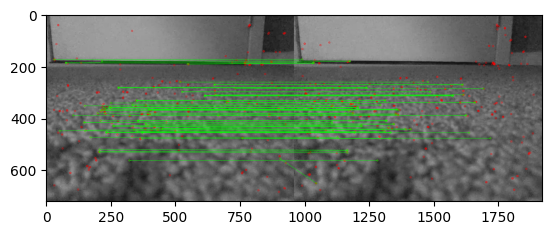

(<matplotlib.image.AxesImage at 0x13ffa4450>, None)

In [ ]:
# uncommented for testing later in the notebook
img1 = frames[2]
img2 = frames[3]

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# initializing ORB
orb = cv2.ORB_create()

kp1, d1 = orb.detectAndCompute(img1, None)
kp2, d2 = orb.detectAndCompute(img2, None)

# FLANN parameters.
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=100) 

# feature matching
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(d1,d2,k=2)

# selecting only good matches.
matchesMask = [[0,0] for i in range(len(matches))]

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

In [ ]:
print(matches[0][1].queryIdx, matches[0][1].trainIdx)

0 221


In [ ]:
pt1 = cv2.KeyPoint_convert(keypoints_1)
pt2 = cv2.KeyPoint_convert(keypoints_2)

print(pt1[265], pt2[309])

[416.79367 277.86243] [138.93121 400.20486]
